In [1]:
import os
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from bayesflow import benchmarks
from bayesflow.amortizers import (
    AmortizedPosterior,
    AmortizedLikelihood,
    AmortizedPosteriorLikelihood,
)
from bayesflow.networks import InvertibleNetwork, DeepSet
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_losses

In [ ]:
# Comment out, if you want tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Benchmark: Bernoulli GLM Raw

In [3]:
benchmark_name = "bernoulli_glm_raw"
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the bernoulli_glm_raw model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [4]:
# Summary network will be a small permutation-invariant network
summary_net = DeepSet(32)

# Amortizer setup
amortizer = AmortizedPosteriorLikelihood(
    # Posterior amortizer
    AmortizedPosterior(
        inference_net=InvertibleNetwork(
            num_params=10,
            num_coupling_layers=6,
            coupling_design="spline",
            permutation="learnable",
        ),
        summary_net=summary_net,
    ),
    # Likelihood amortizer
    AmortizedLikelihood(
        InvertibleNetwork(
            num_params=2,
            num_coupling_layers=6,
            coupling_design="spline",
            use_soft_flow=True,
        )
    ),
)

In [5]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=partial(benchmark.configurator, as_summary_condition=True),
    checkpoint_path=f"checkpoints/{benchmark_name}",
    memory=False,
    max_to_keep=1,
)

INFO:root:Loaded loss history from checkpoints/bernoulli_glm_raw/history_50.pkl.
INFO:root:Networks loaded from checkpoints/bernoulli_glm_raw/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall clock time on GPU: 41min 18s

In [6]:
# EPOCHS = 50
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 32

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [7]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

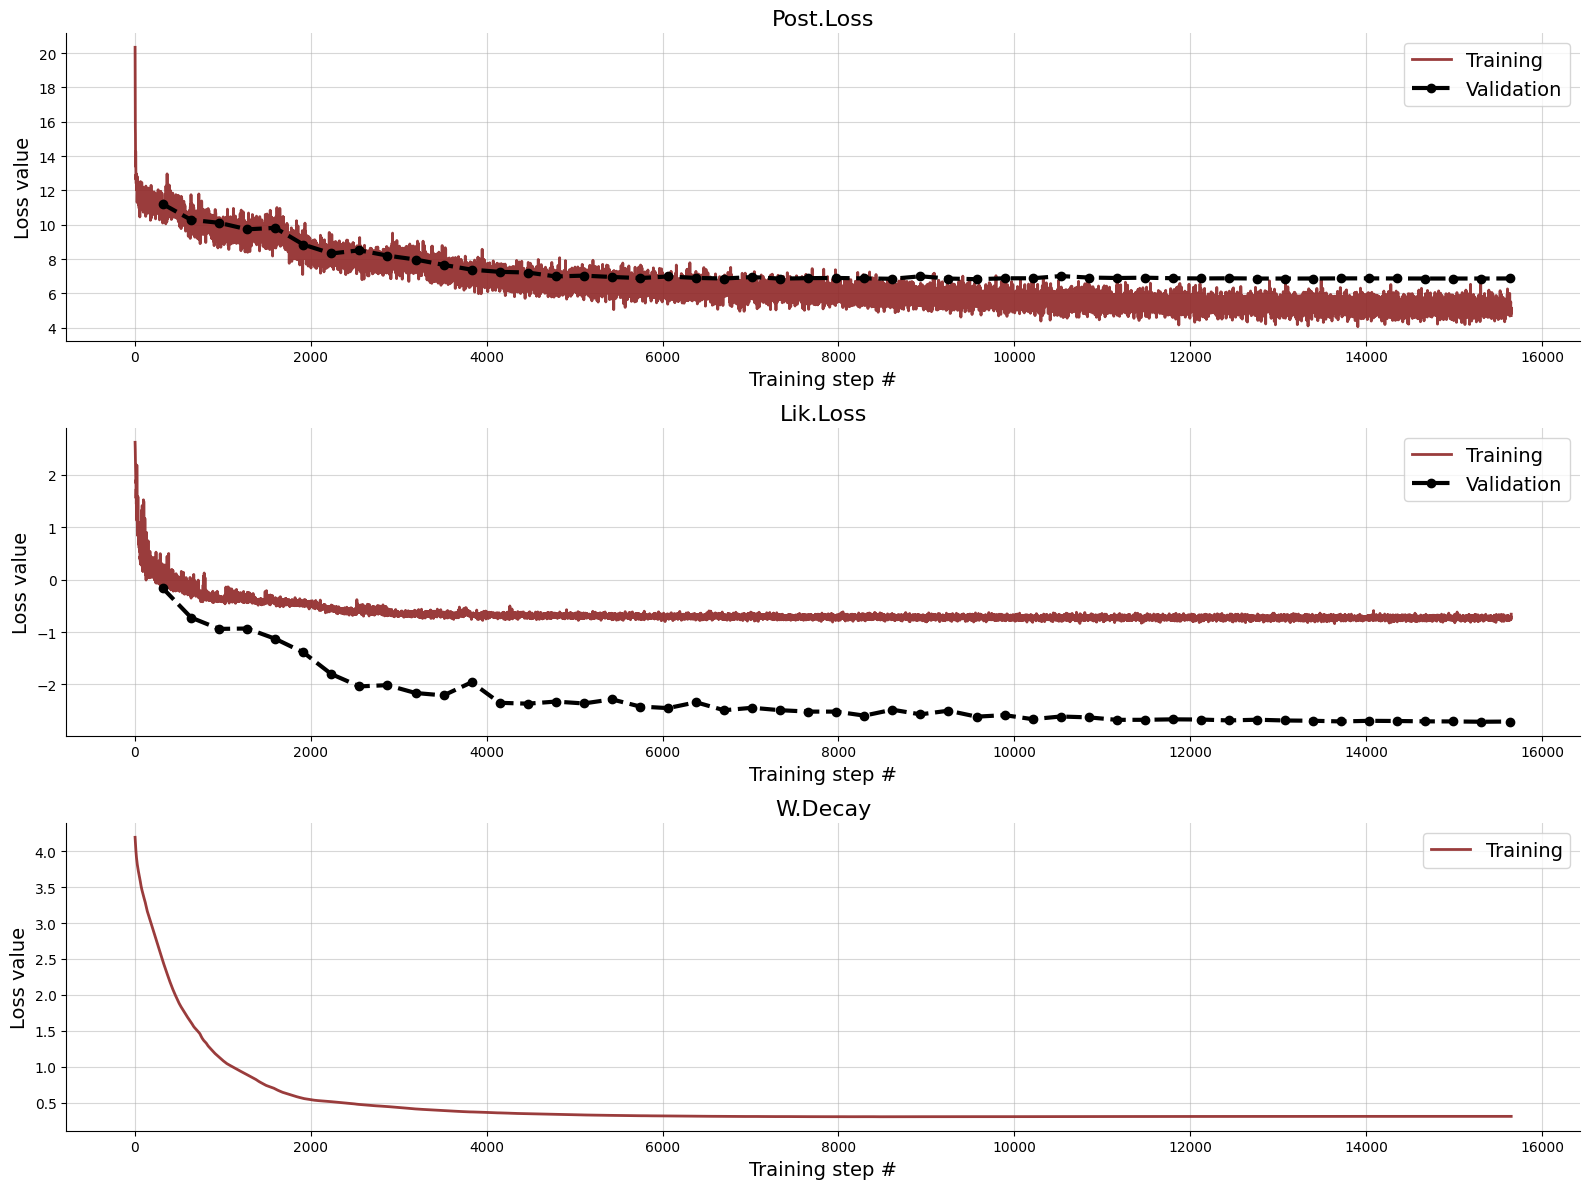

In [8]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h["train_losses"], h["val_losses"])

In [9]:
# Load test data
with open(f"test_data/{benchmark_name}_test.pkl", "rb") as f:
    test_dict = pickle.load(f)

In [10]:
num_post_samples = 250

# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=100)[:, :, 0:1]
x_sim_s = np.abs(np.round(x_sim_s))

# Sample from posteriors given surrogate outputs
cond = test_dict["posterior_inputs"]["summary_conditions"][:, :, 1:]
cond = np.concatenate([x_sim_s, cond], axis=-1)
post_samples_s = amortizer.sample_parameters(
    {"summary_conditions": cond}, n_samples=num_post_samples
)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=num_post_samples)

# Prior samples
prior_samples = test_dict["posterior_inputs"]["parameters"]

## Calibration

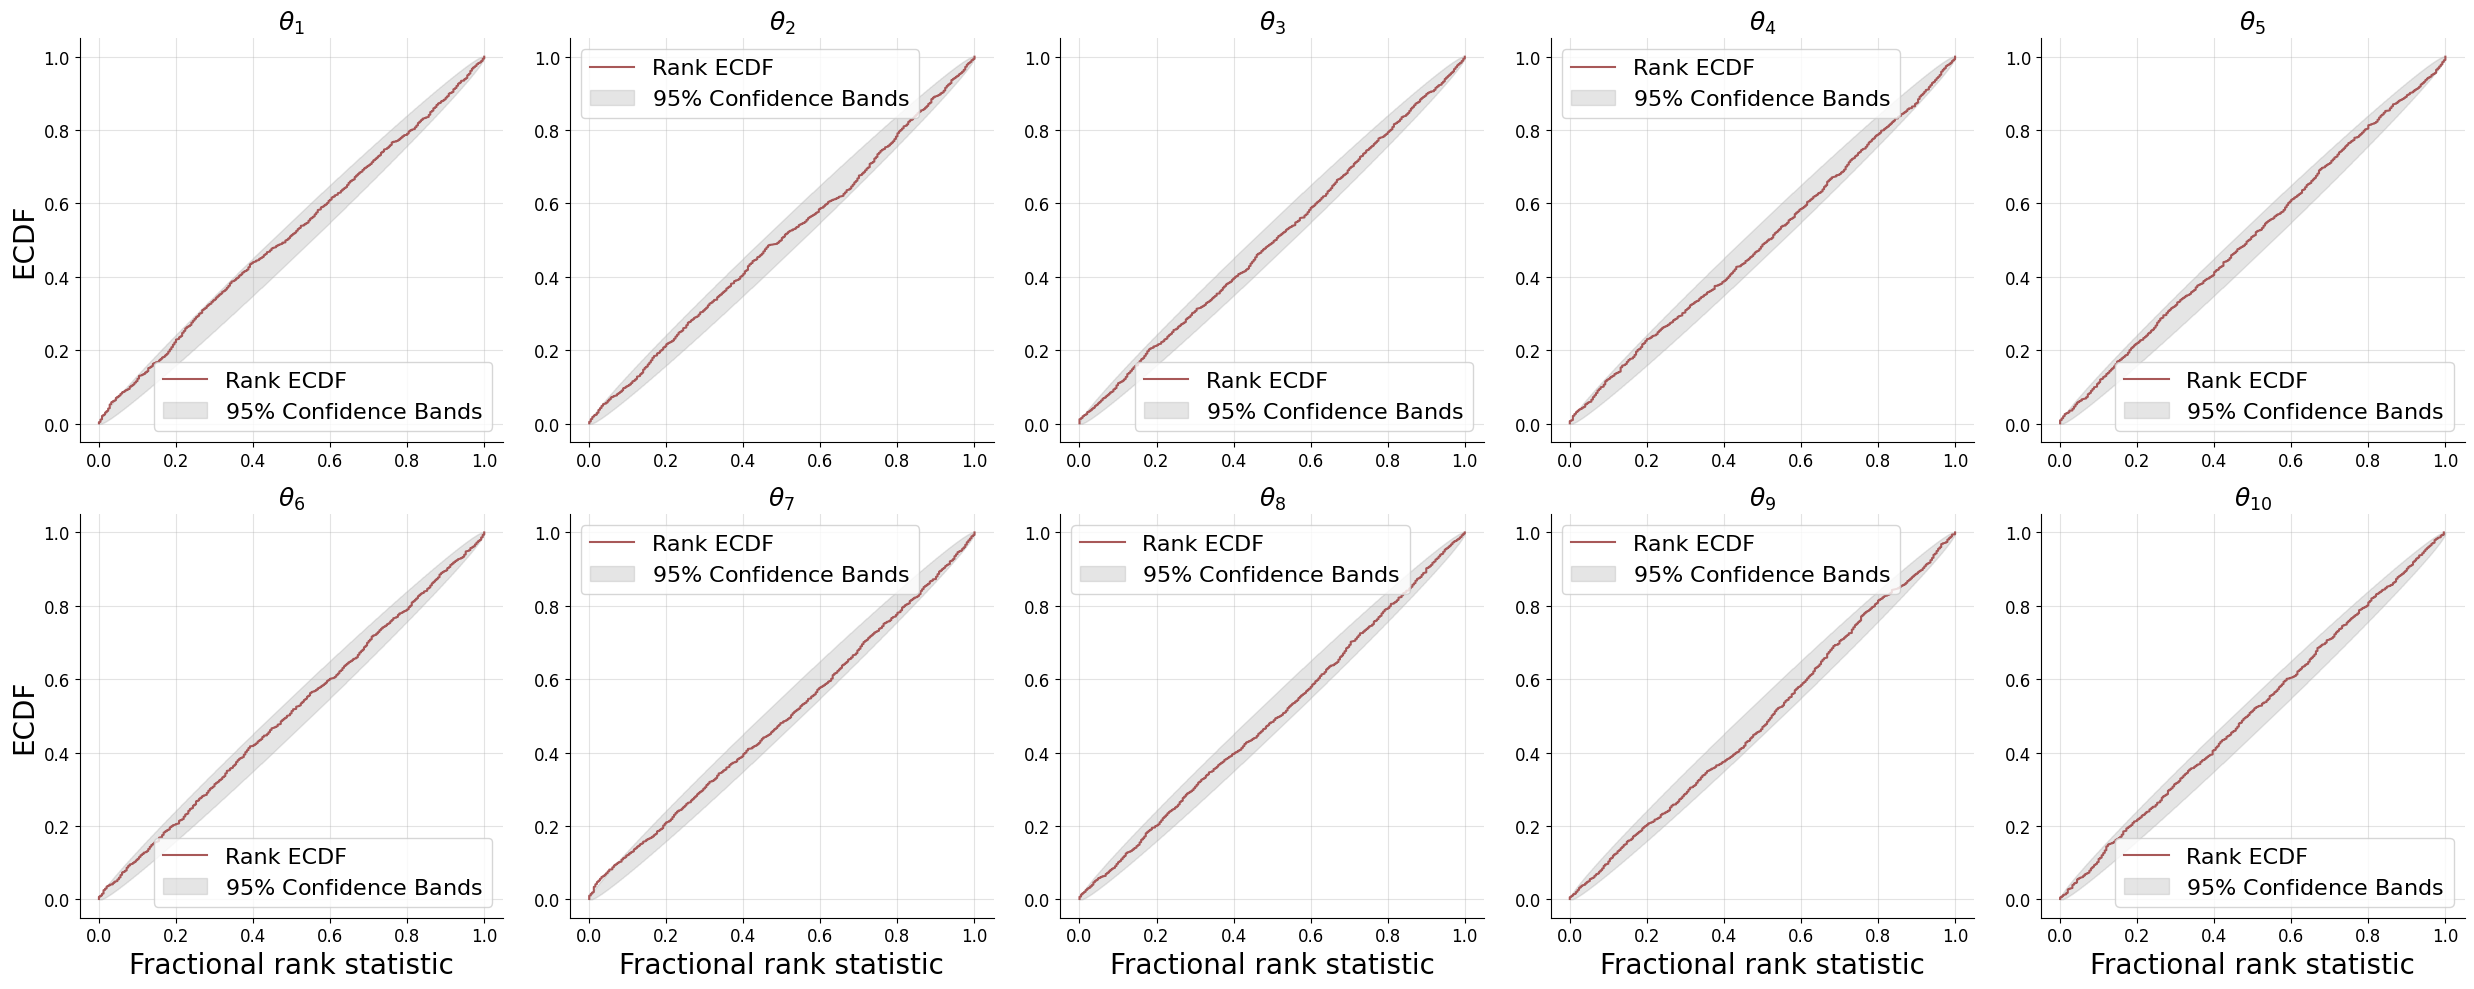

In [11]:
f = plot_sbc_ecdf(
    post_samples_s,
    prior_samples,
    ecdf_bands_kwargs=dict(confidence=0.95),
    label_fontsize=20,
    legend_fontsize=16,
)

## Recovery

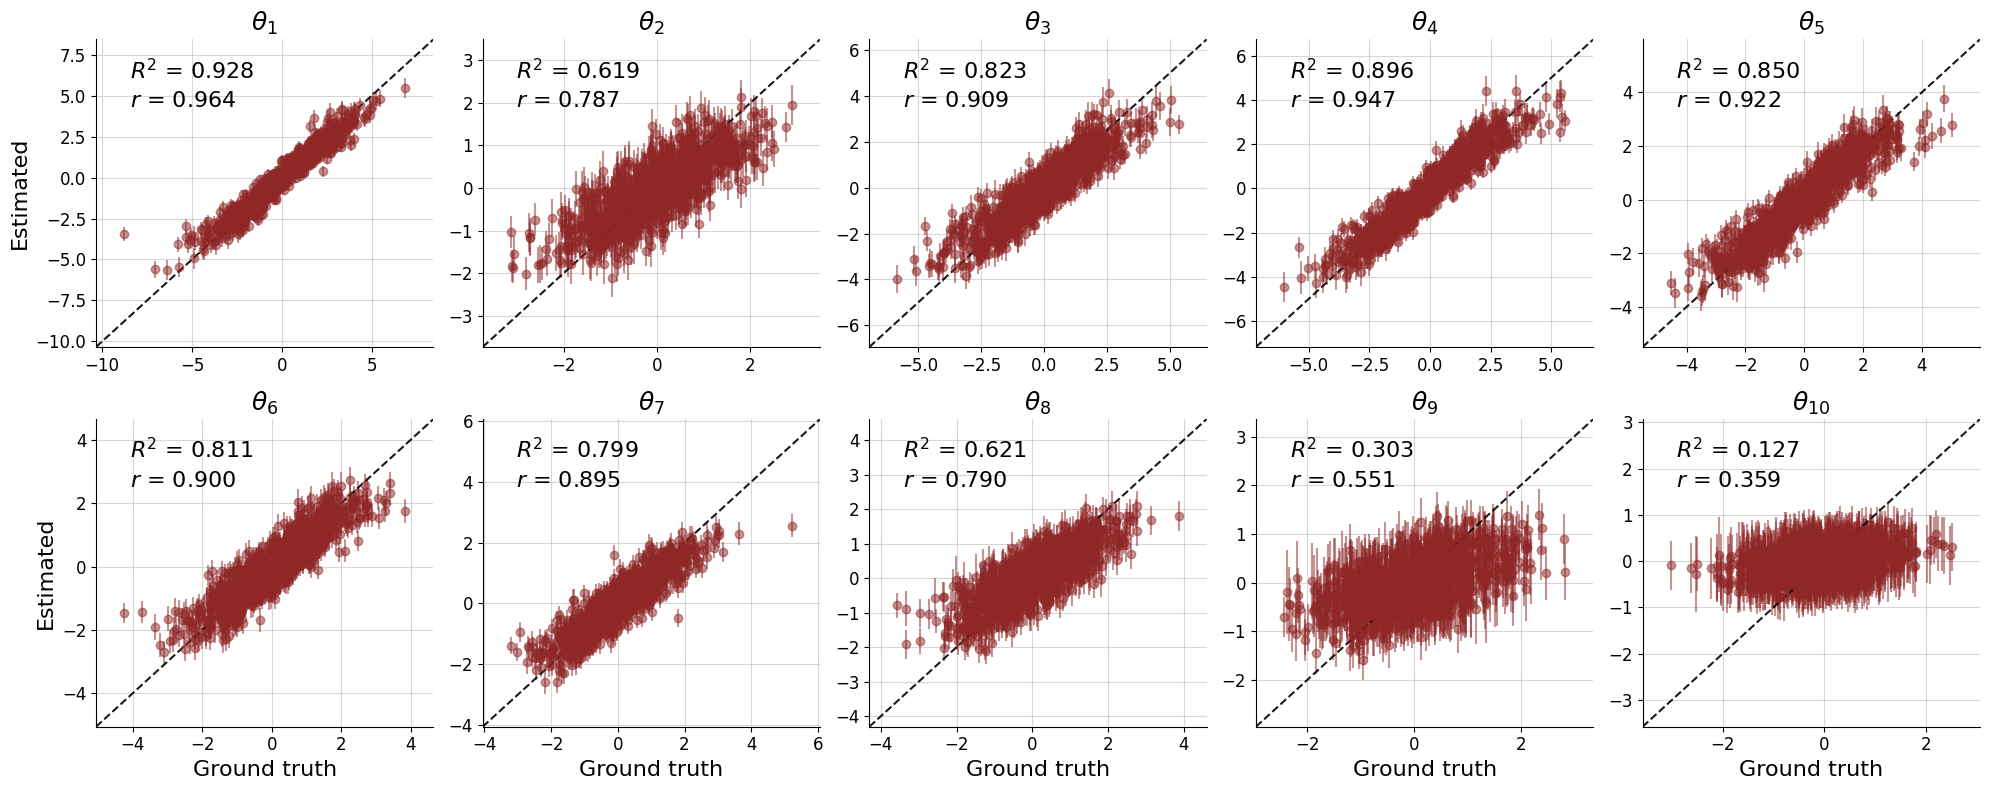

In [12]:
f = plot_recovery(post_samples, prior_samples)

# Appendix Plots

In [13]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{{amsmath}}",
    }
)

### Loss History

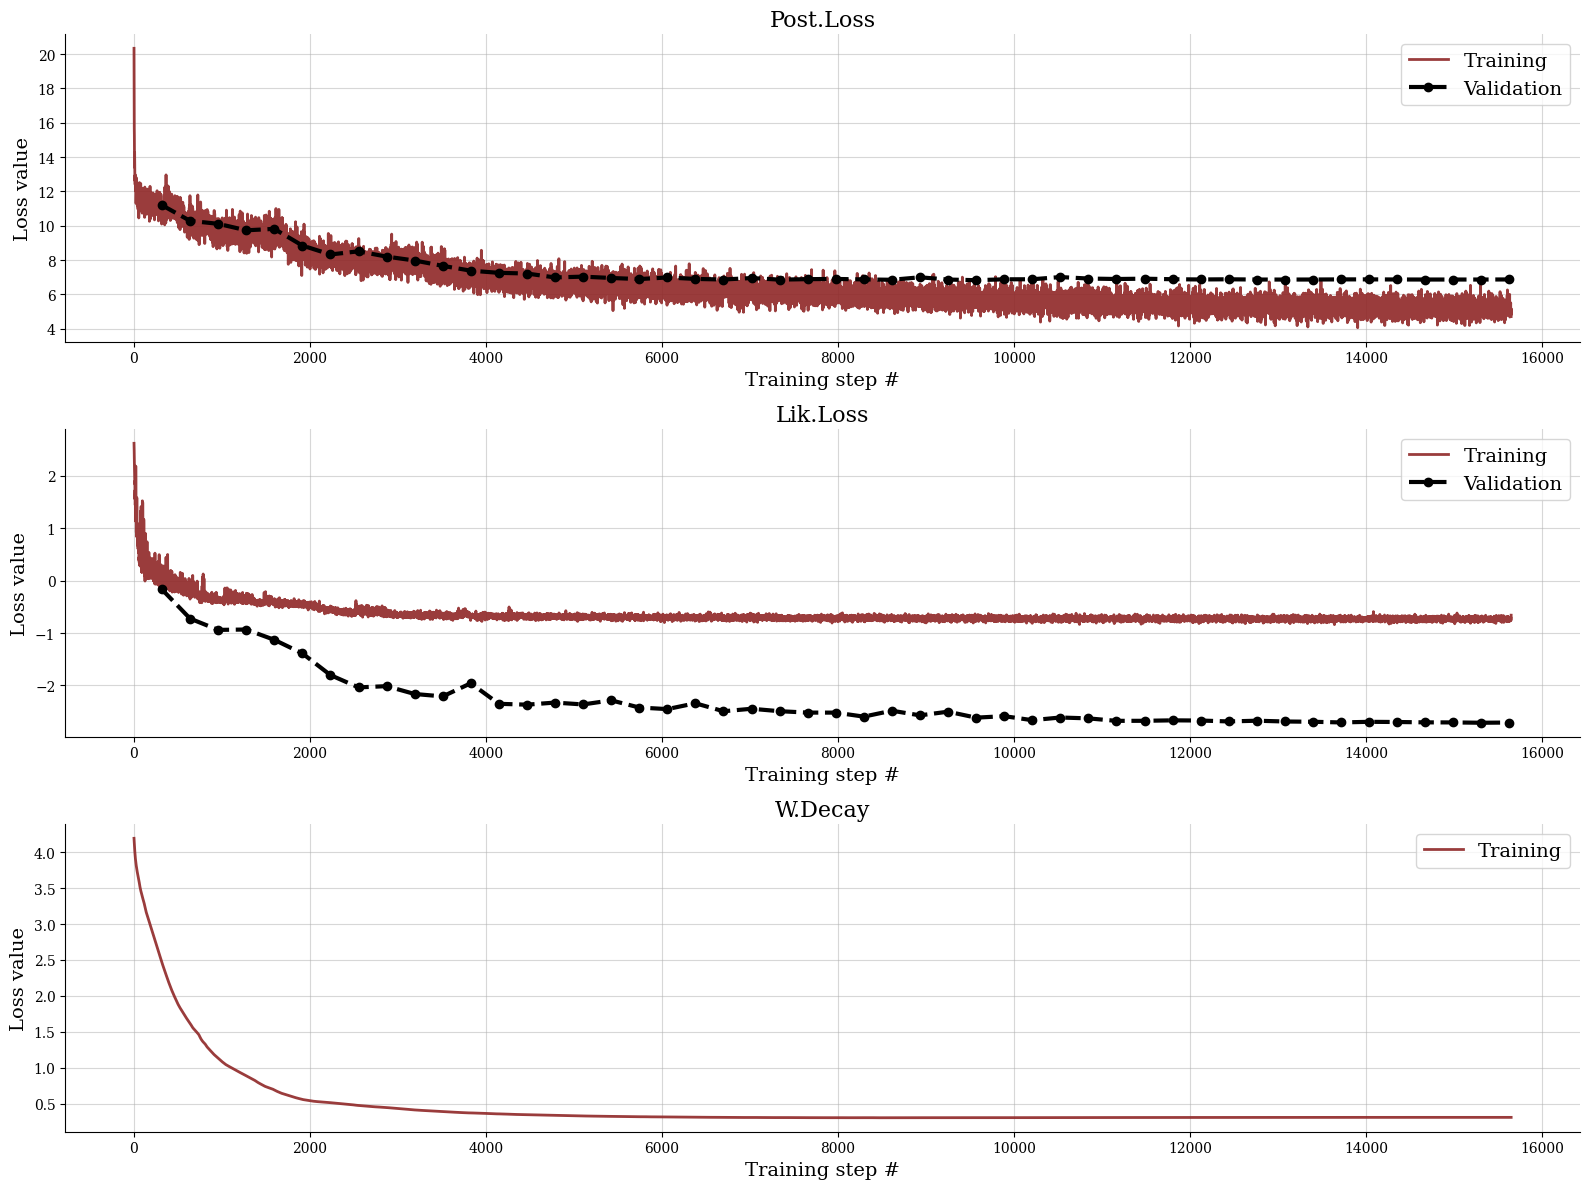

In [14]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h["train_losses"], h["val_losses"])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

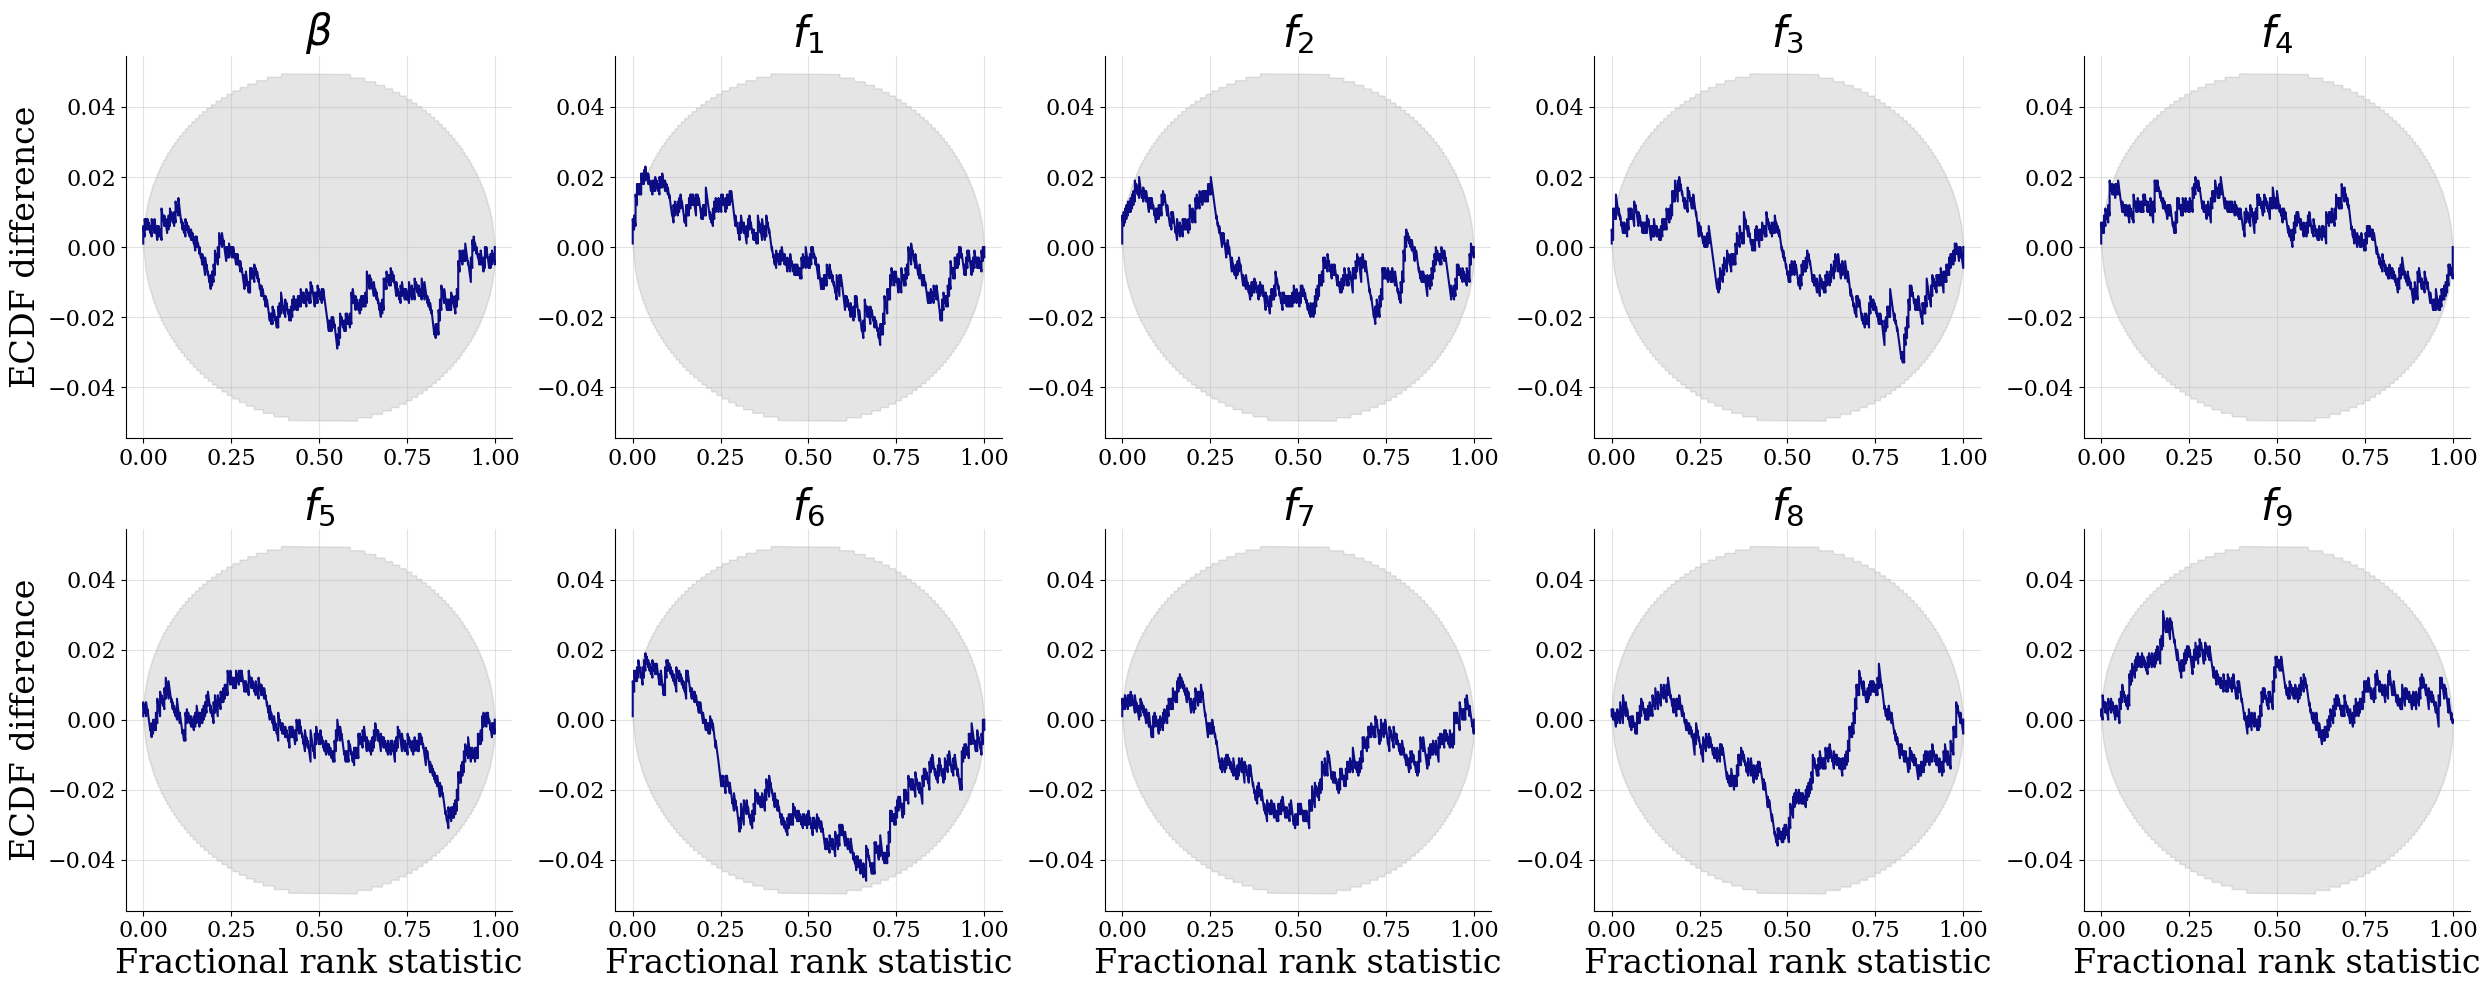

In [15]:
f = plot_sbc_ecdf_appendix(
    post_samples,
    prior_samples,
    ecdf_bands_kwargs=dict(confidence=0.95),
    param_names=benchmark.benchmark_info["parameter_names"],
    label_fontsize=24,
    legend_fontsize=24,
    difference=True,
    rank_ecdf_color="#000080",
)

plt.savefig(
    f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf",
    dpi=300,
    bbox_inches="tight",
)

### Joint Calibration

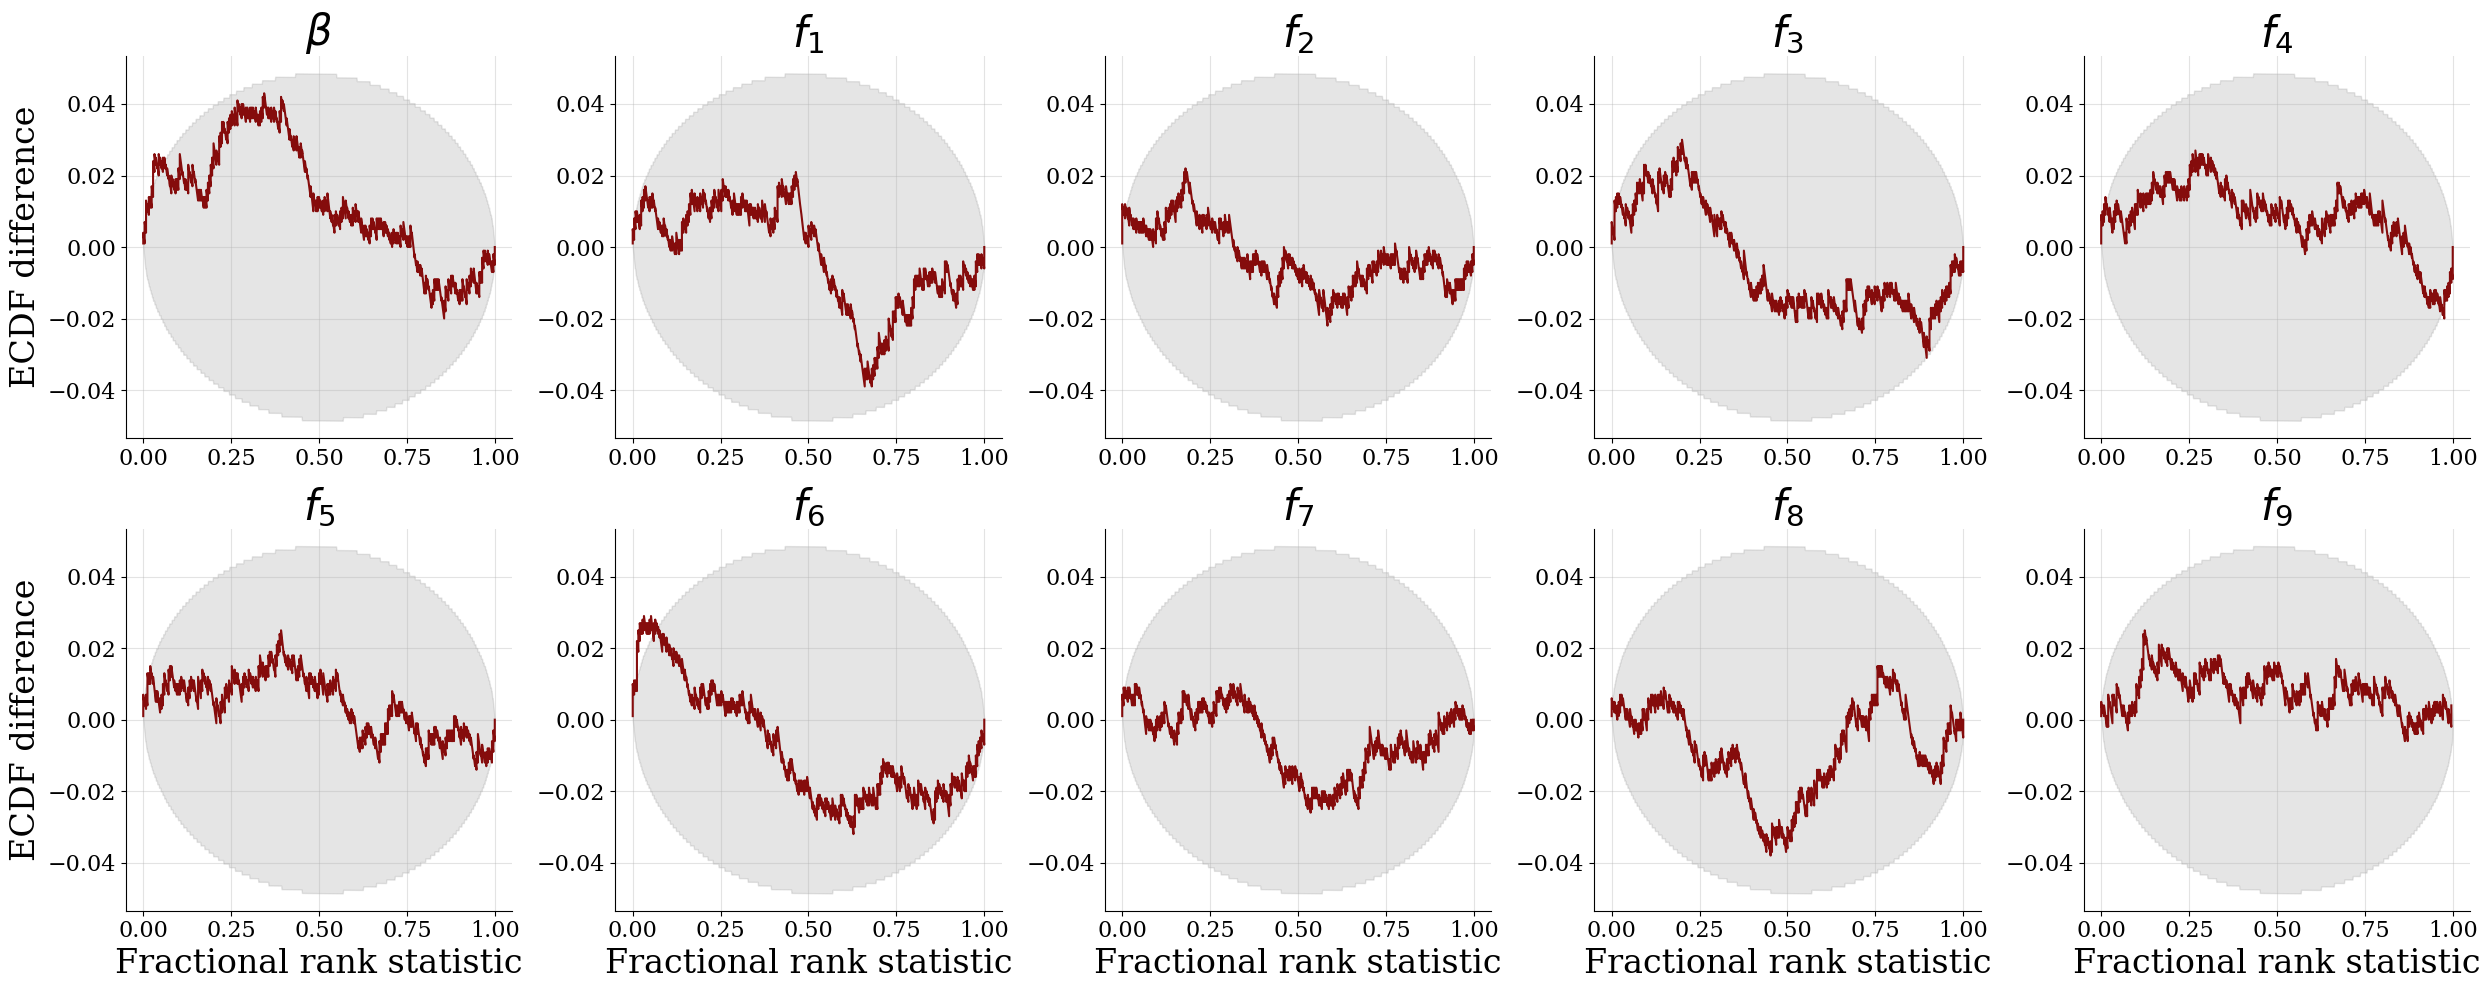

In [16]:
f = plot_sbc_ecdf_appendix(
    post_samples_s,
    prior_samples,
    ecdf_bands_kwargs=dict(confidence=0.95),
    param_names=benchmark.benchmark_info["parameter_names"],
    label_fontsize=24,
    legend_fontsize=24,
    difference=True,
    rank_ecdf_color="#800000",
)

plt.savefig(
    f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf",
    dpi=300,
    bbox_inches="tight",
)